In [1]:
## Notebook env: brian_script_env (R kernel)

In [2]:
path = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q25_q75_greater_than_10FPKM_top2000DEGs/'
path2 = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q10_q90_greater_than_10FPKM_top2000DEGs/'


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




[1] FALSE

png 
  2

png 
  2

[1] 72.4063

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
When using repel, set xnudge and ynudge to 0 for optimal results



png 
  2

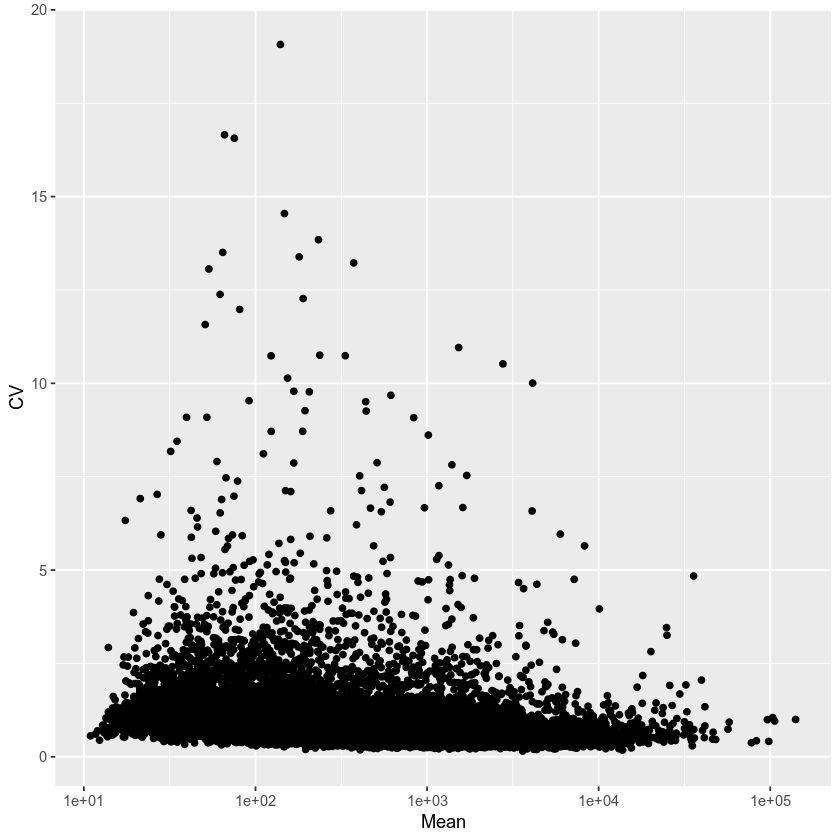

In [3]:
#' ---
#' title: "Analyzing BRCA TCGA data, FPKM data of **medium to high expressing** genes using Brian's script"
#' output: html_notebook
#' ---
#' 
#' This is modified version of Brian's q25 and q75 script: 'Analysis_heterogeneity_BRCA_TCGA_FPKM_approach_q25_q75.Rmd'
#' 
#' Let's create a mean vs CV graph for the patients to create a remove low expressing genes with high variability from our analysis
#' 
## ------------------------------------------------------------------------------

library(ggplot2)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(Seurat)

## load in data
RNA_Seq_expression_raw_data <- 
read.delim("/home/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_RNA_Seq_v2_expression_median.txt", stringsAsFactors = FALSE)

#The 'all' approach to check if all values in a row are 0
check_if_not_zero <- function (vector, number = 0) {
  if (!(all (vector == number))) {
    return (TRUE) #if not zero, then returns TRUE
  }
  else{
    return(FALSE)
  }
}

#See if there are any rows that are FALSE, meaning that are actually all 0
all(as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))) 
zero_genes = as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))

##take out genes with no expression in any of the patients
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data[as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero))),]


gene_medians = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, median)

median_df = data.frame(medians = gene_medians)

pdf(paste0(path, 'gene_expression_pre_filter1.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 500) +
  geom_vline(xintercept = 10, color = 'blue') +
  theme_bw()
dev.off()

pdf(paste0(path, 'gene_expression_pre_filter2.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 50000) +
  geom_vline(xintercept = 10, color = 'blue') + coord_cartesian(xlim = c(0,200)) +
  theme_bw()
dev.off()


pct_genes_left = function(median_expression, cutoff){
  pct = 100*length(which(median_expression >= cutoff))/length(median_expression)
  return(pct)
}

pct_genes_left(gene_medians, 10)

### removing genes with medians < 10 keeps 72% of genes -- low expressing genes have noisy expression and confound results ###

genes_to_keep = as.numeric(gene_medians) >= 10
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data[genes_to_keep,]

gene_means = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, mean)
gene_CVs = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, function(x){sd(x)/mean(x)})

gene_var = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, var)

raw_counts = as.matrix(RNA_Seq_expression_raw_data[, -c(1,2)])
rownames(raw_counts) <- RNA_Seq_expression_raw_data$Hugo_Symbol
na_idx <- is.na(rownames(raw_counts))
rownames(raw_counts)[na_idx] <- 'Unknown'


rna_seq_seurat <- CreateSeuratObject(counts = raw_counts)
rna_seq_seurat <- NormalizeData(rna_seq_seurat)
rna_seq_seurat <- FindVariableFeatures(rna_seq_seurat)
head(VariableFeatures(rna_seq_seurat), 2000) -> var.genes
VariableFeaturePlot(rna_seq_seurat) -> plot1
top10 <- head(VariableFeatures(rna_seq_seurat), 10)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)

pdf(paste0(path, 'var_genes_2000DEGs.pdf'), width = 10, height = 10)
plot2
dev.off()

gene_level_df = data.frame(Gene_name = RNA_Seq_expression_raw_data$Hugo_Symbol, Mean = gene_means, CV = gene_CVs)

ggplot(gene_level_df, aes(Mean, CV)) + geom_point() + scale_x_log10(breaks = log_breaks(5))


[1] 914

[1] 2463

[1] 493

[1] TRUE

[1] TRUE

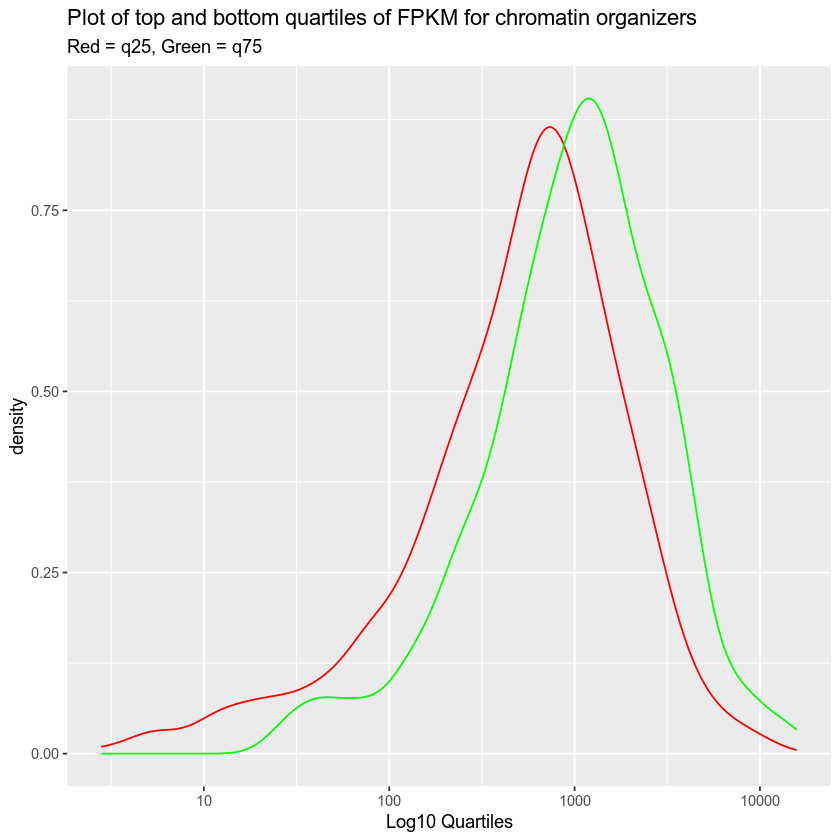

In [4]:
#' Copy and paste Brian's analysis from this point on
## ---- Data loading-------------------------------------------------------------

#Load in chromatin organization modifiers. How this was found: GO term, eukaryota => #mammalia => homo sapiens. Gives a list of gene products; there's non-unique entries #(contributed by different sources, etc)

chromatin_modifiers <- read.delim("/home/ssobti/projects/heterogeneity_brian/uploaded_data/Chromatin_modifiers.txt", header=FALSE, stringsAsFactors=FALSE)

#the first column is the one of interest
colnames(chromatin_modifiers)[1] <- 'Gene Names'

chrom_list_to_sort_against <- unique(chromatin_modifiers$`Gene Names`)

#check lengths of new and original list from chromatin modifiers

length(chrom_list_to_sort_against) 
length(chromatin_modifiers$`Gene Names`)

#logic to extract the chromatin modifier genes specifically from the full RNA Seq list.
#Use the %in% operator to (vector-wise) get the rows specifically. Use this to get
#the quartiles for each gene:

set.seed(42)

chromatin_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% chrom_list_to_sort_against,]

#And these are the 'true' groupings. Let's add a column to denote that here, in front
#of the first two columns using the 'add_column' function from tibble library:

chromatin_genes_RNA_seq <- add_column(chromatin_genes_RNA_seq,
                                      Random = 'N', .after = 2)

length(rownames(chromatin_genes_RNA_seq))

#We'd like to also derive a background distribution for all of these genes. To do so,
#let's append 50 genes that are randomly selected from the dataset, and their #corresponding rows. 

random_genes <- sample(RNA_Seq_expression_raw_data$Hugo_Symbol, 50)
random_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% random_genes,]

random_names <- random_genes_RNA_seq$Hugo_Symbol

#Let's also add an equivalently named column here to denote that these are the random genes: 

random_genes_RNA_seq <- add_column(random_genes_RNA_seq, Random = 'Y', .after = 2)

full_genes_RNA_seq <- rbind(chromatin_genes_RNA_seq, random_genes_RNA_seq)

length(rownames(full_genes_RNA_seq)) == 
length(rownames(chromatin_genes_RNA_seq)) + length(rownames(random_genes_RNA_seq)) #TRUE

#creating a threshold with which to create 'hi' vs 'lo' populations of patients; here, I #choose to use top vs bottom quartile. Need to apply quantile across the rows of the #chromatin_genes data frame, excluding the first observation (which is a character string #of the gene name in question)

q25 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.25), na.rm = TRUE)

q75 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.75), na.rm = TRUE)


full_genes_RNA_seq <- add_column(full_genes_RNA_seq, q25 = q25, q75 = q75, .after = 3)

all (full_genes_RNA_seq$q25 <= full_genes_RNA_seq$q75) #true

#Also remove data where the bottom quartile is 0 FPKM. This doesn't seem like it would
#provide any meaningful data to a CV comparison.

full_genes_RNA_seq <- 
full_genes_RNA_seq[!(full_genes_RNA_seq$q25 == 0),]

#Viewing the data and indices

ggplot(full_genes_RNA_seq) + geom_density(aes (x = q25), color = 'red') +
geom_density (aes (x = q75), color = 'green') + 
labs (title = 'Plot of top and bottom quartiles of FPKM for chromatin organizers', 
      subtitle = 'Red = q25, Green = q75',
      x = 'Log10 Quartiles') + 
scale_x_log10()

In [5]:
#' ### Getting groupings of the data based on chromatin modifier expression
#' 
#' We've now completed some EDA of the data and cleaning of useless chromatin modifier factors that wouldn't be good for grouping. Now, let's get dataframes corresponding to these groupings in a list format to each unique chromatin modifier, then use these groupings to get subsetted dataframes from the full dataset corresponding to bottom/top expressers of each chromatin modifier.
#' 
## ---- Getting lo/hi groupings--------------------------------------------------

#Now I want lo and hi expressers (below q25, above q75) for each gene. Way to approach #this: create different groupings, based on hi/lo threshold. To first get the groupings #and return #them in a list: define a function that returns up to three entries in list #format. These are: Gene name, all names below the bottom quantile, and all names above #the top quantile.

groupings_returner <- function (gene, chromatin_data, gene_col = 1, random = 3, 
                                q25_col = 4, q75_col = 5) {
  #the q25_col, q75_col are last two columns in the data frame
  q25 = chromatin_data[chromatin_data[,gene_col]==gene, q25_col] 
  q75 = chromatin_data[chromatin_data[,gene_col]==gene, q75_col]
  rand_designation = chromatin_data[chromatin_data[,gene_col]==gene, random] 
  #get the q25, q75 'indices'
  row = chromatin_data[chromatin_data[,gene_col]==gene, c(-1:-2, -random, 
                                                          -q25_col, -q75_col)]
  #eliminate gene ID, the q25 and q75 columns; isolate a single row
  col = data.frame(t(row)) 
  #get into column format for easy use of row subsetting techniques
  colnames(col) = 'expression_levels'
  list_below_25 = rownames(col[col$expression_levels <= q25,, drop= FALSE]) 
  #to keep row names
  list_above_75 = rownames(col[col$expression_levels >= q75,, drop= FALSE])
  return (list(gene, rand_designation, list_below_25, list_above_75)) 
  #list of 3 entries. First = gene, second = bottom quartile, third = top quartile
}

#let's test that this function works as intended: make a 'test' vector that corresponds 
#to the ACTB gene, then compare this to the corresponding list in the full list.
#Note that the 1103 and 1104 columns correspond to the q25, q75 columns correspondingly.

test <- groupings_returner('HDAC2', full_genes_RNA_seq)

str(test) #should look like a 4 item list

#Some warnings will occur: this is because I sampled 50 randomly from the full dataset.
#Some overlapped with the list of chromatin modifiers list. This seems reasonable to 
#keep though.

groupings <- lapply(full_genes_RNA_seq$Hugo_Symbol, groupings_returner,                                       full_genes_RNA_seq)
str(groupings)

groupings[[2]][2] %in% test[3] #false

groupings[[1]][2] %in% test[2] #TRUE

#should have list of length equal to the chromatin gene list, with two or three entries #in each entry of the list

length(groupings) == length(full_genes_RNA_seq$Hugo_Symbol) 

#Now, using this list of groupings, I should then create dataframes corresponding to each
#groupings list, i.e. for below bottom quantile and above top quantile. This function #should take in a 'key' (each LIST entry within the groupings list) and return either #nothing, or two dataframes.

dataframe_returner <- function (key, full_data, additional_col_vectors = c(),
                                key_gene_entry = 1, key_random_entry = 2, 
                                key_25_entry = 3, key_75_entry = 4) {
    #additional_col_vectors fetches columns by name
  
    #Idea is to aggr. the columns that correspond to the 'correct' patients for each
    #quartile grouping
    q25_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_25_entry]])]
    #key_2/75_entry is a numeric index
    q75_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_75_entry]])]
    return (list(key[[key_gene_entry]], key[[key_random_entry]],
                 q25_dataframe, q75_dataframe))
}

#As a test: try this with the first gene entry from the above groupings data structure. #Expect: a three-entry list, with the first entry being the gene name, the second and #third being the corresponding data frames. Should have a dataframe with gene IDs, #followed by expression levels.

#use names in this vector to fetch columns corresponding to these two names
gene_vec <- c('Hugo_Symbol', 'Entrez_Gene_Id') 

#check that this list looks correct for a random gene, ACTL6A, index 1)
str(dataframe_returner(groupings[[1]], RNA_Seq_expression_raw_data, gene_vec)) 

#Code to actually get the grouped data
grouped_dataframes_list <- lapply(groupings, dataframe_returner, 
                                  RNA_Seq_expression_raw_data, gene_vec)

#' 
#' ### Appending CVs, CV ratios, to the grouped dataframe object
#' 
#' Let's now calculate CVs and the corresponding CV ratios for each gene between the bottom 
#' and top quartile groups. We will append these to the current grouped dataframes list object made in the previous code chunk. These will be used to determine whether a gene 
#' went up or down in its CV between lower and higher expression of the chromatin modifier in question.
#' 
## ---- Appending CVs------------------------------------------------------------
#First define a coefficient of variation function and apply across each row of the #dataframes in the grouped list:

coeff_variation <- function (vector) {
  return (sd(vector)/abs(mean(vector)))
}

#Calculate coefficient of variation for the entire grouped dataframes list.
#First define a helper function that takes in a list, and applies the given 
#function to the specified entries of the list (here, would like these entries to be the
#second and third entries). It then adds a new column corresponding to the values it 
#calculated. 

#### edited out non-DEG genes here ####


var.genes.idx <- match(var.genes, row.names(rna_seq_seurat@assays$RNA))
lower <- lapply(lapply(grouped_dataframes_list, '[[', 3), function(df){return(df[var.genes.idx,])})
upper <- lapply(lapply(grouped_dataframes_list, '[[', 4), function(df){return(df[var.genes.idx,])})

for (i in 1:length(grouped_dataframes_list)){
  grouped_dataframes_list[[i]][[3]] <- lower[[i]]
  grouped_dataframes_list[[i]][[4]] <- upper[[i]]
}


#omit the two first cols from being within the coeff_var calc, as they correspond to the #name/Gene ID for the gene in question

indices_omit <- -1:-2 

#This function operates at the level of a single dataframe. It takes in a dataframe and 
#returns a modified dataframe that has CV appended to the dataframe as a column. 

col_adjuster <- function (entry, omitted_indices = indices_omit, row_or_col = 1,
                          column_to_add_after = 2, col_name = 'CV',
                          f = coeff_variation, ...) {
  if (is.data.frame(entry)) {
    #has this is.data.frame entry so I can just simply apply this function across 
    #all of the list entries in the df_list that contain either df's or strings
      "... refers to the arguments of 'f'"
      col_result <- apply(entry[, omitted_indices], row_or_col, f, ...)
      #print(CV)
      entry <- add_column (entry, name = col_result, .after = column_to_add_after)
      colnames(entry)[colnames (entry) == 'name'] <- col_name 
      #adds the CV col (result of applying the function f) to original entry dataframe,
      #reassigning the name to match the name of the (statistic) calculated, e.g. CV, etc
  return (entry)
 #return the modified entry
  } else {
    return (entry)
  }
}

#Double apply call: nested lapply call works at the single list of dataframe level, 
#and the outer lapply call works to apply this across the entire grouped_dataframes_list
#object

grouped_dataframes_list_with_CV <- pblapply(grouped_dataframes_list, function (list) {
  lapply (list, col_adjuster) })

#Check that manually calculating CV gives the same result as this above call:

test_CV <- coeff_variation(as.numeric(grouped_dataframes_list[[2]][[3]][2,-1:-2]))

CV_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][2,]$CV

CV_not_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][50,]$CV

test_CV == CV_to_match #TRUE

test_CV == CV_not_to_match #FALSE
                                
#Now, take the ratios of the CV values. After doing this, then will have e.g. ~20440 #ratios. This function below works at the level of a 3-entry list, with one specified #entry in the list being a dataframe corresponding to bottom quantile, and vice versa for #top quantile.

CV_divider <- function (list, CV_index = 3, q25_entry = 3, q75_entry = 4) {
  #Calculate the CV ratio between q25 and q75 by dividing the two respective cols
  CV_ratio <- list[[q25_entry]][, CV_index]/list[[q75_entry]][, CV_index]
  
  list[[q25_entry]] <- add_column(list[[q25_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  #adds a CV_ratio column to the bottom quantile dataframe in the list
  list[[q75_entry]] <- add_column(list[[q75_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  return (list)
}

#See if this function works for just one entry in the full dataframe list (i.e. a 3-
#entry list)

test_CV_ratio <- CV_divider(grouped_dataframes_list_with_CV[[2]])

test_CV_ratio[[3]]$CV_ratio #should exist

grouped_dataframes_list_with_CV_ratio <- lapply(grouped_dataframes_list_with_CV, 
                                                CV_divider)

#Remove rows with NaN: define a function that removes all rows that are NaN for the 
#specified CV_ratio column (here, the 4th index). This meant that all of the rows
#were 0 for either the q25 grouping or q75 grouping, not unexpected (many genes 
#had high levels of 0's in the full dataset).

#!!Huge memory sink!! NEED TO FIX THIS. MEMORY VIRTUAL EXHAUSTED

#options (future.globals.maxSize = 4000 * 1024^5)

NaN_omitter <- function (entry, CV_ratio_col = 4) {
  if (is.data.frame(entry)) {
    return (entry[is.finite (entry[, CV_ratio_col]) ,])
  } else {
    return (entry)
  }
}

lapply_wrapper <- function (df_list, f) {
  return (lapply(df_list, f))
}

grouped_dataframes_list_with_CV_ratio_cleaned <- pblapply(grouped_dataframes_list_with_CV_ratio, lapply_wrapper, NaN_omitter)

#check that names match:
names_list <- lapply(grouped_dataframes_list, function (list) list[[1]])

names_CV_ratio <- lapply(grouped_dataframes_list_with_CV_ratio, function (list) 
  list[[1]])

names_CV_clean <- lapply(grouped_dataframes_list_with_CV_ratio_cleaned, function (list) 
  list[[1]])

identical(names_list, names_CV_ratio)

identical(names_list, names_CV_clean)

save(grouped_dataframes_list_with_CV_ratio_cleaned, file = paste0(path, 'gped_clean_df_CV_ratio_q25_q75.RData'))

List of 4
 $ : chr "HDAC2"
 $ : chr "N"
 $ : chr [1:275] "TCGA.3C.AAAU.01" "TCGA.3C.AALI.01" "TCGA.3C.AALJ.01" "TCGA.5T.A9QA.01" ...
 $ : chr [1:275] "TCGA.A1.A0SB.01" "TCGA.A1.A0SJ.01" "TCGA.A1.A0SK.01" "TCGA.A1.A0SO.01" ...
List of 543
 $ :List of 4
  ..$ : chr "ACTL6A"
  ..$ : chr "N"
  ..$ : chr [1:275] "TCGA.5L.AAT1.01" "TCGA.A1.A0SD.01" "TCGA.A1.A0SG.01" "TCGA.A2.A04W.01" ...
  ..$ : chr [1:275] "TCGA.5T.A9QA.01" "TCGA.A1.A0SI.01" "TCGA.A1.A0SJ.01" "TCGA.A1.A0SK.01" ...
 $ :List of 4
  ..$ : chr "ACTR5"
  ..$ : chr "N"
  ..$ : chr [1:275] "TCGA.3C.AALJ.01" "TCGA.A1.A0SB.01" "TCGA.A1.A0SE.01" "TCGA.A1.A0SH.01" ...
  ..$ : chr [1:275] "TCGA.3C.AAAU.01" "TCGA.3C.AALI.01" "TCGA.5L.AAT1.01" "TCGA.5T.A9QA.01" ...
 $ :List of 4
  ..$ : chr "ACTR6"
  ..$ : chr "N"
  ..$ : chr [1:275] "TCGA.3C.AAAU.01" "TCGA.3C.AALI.01" "TCGA.3C.AALK.01" "TCGA.A1.A0SF.01" ...
  ..$ : chr [1:275] "TCGA.A1.A0SK.01" "TCGA.A1.A0SO.01" "TCGA.A2.A04T.01" "TCGA.A2.A0CM.01" ...
 $ :List of 4
  ..$ : chr "ACTR8"
 

[1] FALSE

[1] TRUE

[1] TRUE

List of 4
 $ : chr "ACTL6A"
 $ : chr "N"
 $ :'data.frame':	14663 obs. of  277 variables:
  ..$ Hugo_Symbol    : chr [1:14663] "LOC149767" "TIMM23" "LOC155060" "KIAA1618" ...
  ..$ Entrez_Gene_Id : int [1:14663] 10357 10431 155060 57714 653553 8225 90288 1 87769 2 ...
  ..$ TCGA.5L.AAT1.01: num [1:14663] 116 1108 209 337 126 ...
  ..$ TCGA.A1.A0SD.01: num [1:14663] 60.3 977.9 83.7 1072.9 226.9 ...
  ..$ TCGA.A1.A0SG.01: num [1:14663] 68.6 1072.8 254.5 733.3 391.3 ...
  ..$ TCGA.A2.A04W.01: num [1:14663] 101.3 1759.8 137.8 853.7 94.6 ...
  ..$ TCGA.A2.A04X.01: num [1:14663] 70.5 1451.2 45.8 429.3 231.1 ...
  ..$ TCGA.A2.A0CK.01: num [1:14663] 114 796 263 132 479 ...
  ..$ TCGA.A2.A0CL.01: num [1:14663] 91.3 738.3 229.4 3055.2 111.6 ...
  ..$ TCGA.A2.A0CO.01: num [1:14663] 97.5 572.7 281.6 698.5 366 ...
  ..$ TCGA.A2.A0CP.01: num [1:14663] 96.5 1263.4 247.3 331.8 731.2 ...
  ..$ TCGA.A2.A0CQ.01: num [1:14663] 86.6 1406.3 400.5 243 544.5 ...
  ..$ TCGA.A2.A0CR.01: num [1:14663] 115 1192 20

[1] TRUE

[1] FALSE

[1] 1.2367392 1.2984917 1.1846751 1.2397905 0.9378774 0.6274752 1.0072800
   [8] 1.1154382 0.7275143 0.7250008 0.6645205 0.9503909 0.7385020 1.0250695
  [15] 1.0016018 0.6609256 1.0883020 0.9574860 0.7343231 0.7678110 1.0708782
  [22] 1.1011040 0.8988971 1.1467974 0.4798758 0.8059680 1.7030507 1.0631210
  [29] 0.9725834 0.5667380 0.6116829 0.8782417 1.7963967 0.6807837 0.9132054
  [36] 1.0300357 0.9809574 0.9578108 0.7682778 0.5793438 1.0130450 0.6897218
  [43] 0.8545666 0.9217252 0.9585661 0.8153591 0.9714350 0.9292241 1.4593272
  [50] 1.0403834 1.4083011 1.1324809 0.9023782 0.9066822 1.2139411 0.8994106
  [57] 0.6687545 0.9055915 0.8371380 0.6561655 0.8925554 1.0016896 0.9826562
  [64] 0.7643453 0.8935433 1.0170117 1.0050376 0.7218481 0.5549420 0.7176262
  [71] 0.9705991 1.1180465 1.1342986 1.2028809 1.8041250 0.6939931 1.0070130
  [78] 1.1178195 0.9412858 0.9834760 0.8567540 0.5966608 1.4664287 1.4543701
  [85] 1.2469864 0.8191823 1.1247736 0.9273055 0.6389513 1.0551546 0.6767425
  [92] 1.0835712 1.5141984 1.2831239 1.1042476 0.9735077 0.9583834 1.0086140
  [99] 0.6840568 0.3856295 0.4580844 1.0283945 1.9289533 1.0447455 0.8975258
 [106] 2.6579695 0.7918955 1.0319452 0.7931617 0.9643301 1.9319303 1.6690424
 [113] 0.9725963 1.4557544 0.8218739 0.8037287 2.6757998 0.9035850 1.3968218
 [120] 0.7533989 0.4360233 1.2108613 1.2329808 0.4729662 1.1741899 0.8053889
 [127] 1.8031947 0.9140442 0.7940551 0.9323176 2.2625780 2.5405588 0.7798193
 [134] 0.7909216 0.8734618 1.0352003 0.8106819 0.8302524 0.9367834 0.9399648
 [141] 1.8062263 0.8560976 1.0561361 0.7351554 0.7433688 1.0846312 0.7929207
 [148] 1.0304217 0.9966658 0.6050538 0.8260541 1.0672384 0.9173896 0.9102539
 [155] 0.7752132 0.8981572 0.9056359 0.7467390 0.3873954 1.3587323 1.1874992
 [162] 1.3693267 0.8171155 1.4775725 0.9395806 1.3702985 0.9078937 1.6840437
 [169] 1.1213914 1.7398139 1.3082397 1.8293188 0.7227976 0.9816939 0.9385344
 [176] 1.6591098 1.0578502 0.9023264 1.0261173 0.7455226 1.3304651 2.1233638
 [183] 0.9609578 0.9852211 1.3423184 0.9624390 0.7937071 0.8874368 1.3115509
 [190] 0.9238745 1.1984528 0.8221172 1.1077489 1.0514048 1.6558372 1.2097091
 [197] 1.1543953 1.1140381 2.8597656 0.9839995 0.8686354 0.7292346 0.9618515
 [204] 1.9888523 0.7571823 1.1464073 1.0619475 0.8928292 1.5133800 1.3178755
 [211] 0.3546914 0.7744847 1.9864677 1.3839545 0.9516355 1.5527228 0.4815708
 [218] 1.2607082 1.9338763 1.4586456 0.8425546 0.9848299 1.3788428 0.7909361
 [225] 0.9373776 1.0851606 1.9052339 0.5942130 1.2965680 1.3443518 0.8838170
 [232] 2.1408330 0.9439436 1.2634311 0.9050214 0.4805306 0.9589281 0.8856214
 [239] 1.0825660 0.9569152 1.5141237 0.9337953 0.8227973 1.0039175 1.3554705
 [246] 1.1749168 0.9151146 1.0100499 0.9720736 0.9351130 0.6333677 0.9540895
 [253] 0.8960217 1.0886242 1.0264087 0.8318018 0.7428145 1.3869185 0.9190880
 [260] 1.0197973 2.0127519 1.2064959 1.7433743 1.3727908 1.3729212 1.2582037
 [267] 1.0618911 0.7385387 1.4794185 1.2490240 1.0290946 1.1602101 0.6223258
 [274] 0.9689471 0.8876413 1.0854375 1.3192369 1.1204070 1.3710854 1.3121103
 [281] 0.9277316 1.2498213 1.1892296 0.8533958 0.5635792 0.3547476 1.6986958
 [288] 0.7748196 0.8145103 1.0662330 0.9478038 1.2096311 1.3909341 1.3570780
 [295] 1.1570169 1.0409555 0.9610350 0.8169210 0.7865888 0.5677455 1.1849541
 [302] 0.8270104 0.6459088 0.9822309 0.9531213 0.8460955 1.1061288 0.8680894
 [309] 0.5673296 0.4218030 1.4273816 1.1043061 0.7399805 0.6351529 1.5514740
 [316] 0.5220809 0.9063601 1.2616210 1.6383420 1.5203000 0.8042727 1.1685394
 [323] 1.3511462 0.7307407 0.8722293 1.1216888 1.0295790 1.1711021 0.2291429
 [330] 0.5741153 3.0217551 2.7014898 4.3684093 0.9835137 0.9407691 0.8696389
 [337] 0.4636221 0.7431262 0.5939972 1.2254207 0.6269503 2.4499853 1.0363346
 [344] 1.0574702 1.0413172 1.1374574 1.1341889 1.2927615 0.8330339 0.7642479
 [351] 0.9848413 0.9364185 0.5952309 0.5105825 1.4111304 0.9825551 0.6494609
 [358] 0.6232388 2.1557953 0.7607374 2.9394147 1.3366367 1.6347072 0.8599325

[1] TRUE

[1] TRUE

In [6]:
#compare to the original set of random names; last entries should all be TRUE
names_CV_clean %in% random_names 

length(grouped_dataframes_list_with_CV_ratio) == length(grouped_dataframes_list_with_CV_ratio_cleaned) #TRUE

#TEMPORARY: to not break further code, move forward with CV ratio object

grouped_dataframes_list_with_CV_ratio_cleaned <- grouped_dataframes_list_with_CV_ratio

#' 
#' ### Using z-score thresholding approach to determine significant genes
#' 
#' Let's now try to use the *grouped_dataframes_list_with_CV_ratios_cleaned* object that was created previously and do a gene-by-gene analysis followed by z-score thresholding at the factor level (very last step).
#' 
#' What I will do now: for each matched row (corresponds to a gene) in q25, q75 dataframes: create a two-entry dataframe with first column being all of the observations, and the second being the grouping variable (q25, q75). Then, run the asymptotic test on this dataframe. Take the p-value and whether or not the CV went down from q25 to q75. Record these two entries.
#' 
## ---- z-score thresholding-----------------------------------------------------
#As a check: first check that the grouped dataframes list input has the same gene name in #every row, and in the right position, for both the q25 and q75 dataframes. I.e. check #that the gene names (first column) are identical for both q25, q75 dataframes.

order_checker <- function (df_list, gene_column = 1, q25_entry = 3, q75_entry = 4) {
#This checks if the order and IDs of the first column in the specified dataframes nested #within the df_list object (a list of dfs) match exactly, returning a logical value.
#This is then iterated over the entire df_list (in the two objects created below, 'list'
#refers EACH INDIVIDUAL ENTRY in the full dataframe list.)
names_q25_list <- lapply(df_list, function (single_list_from_df_list) {
                         return (single_list_from_df_list[[q25_entry]][,gene_column]) } )

#get lists of gene IDs for all q25 dataframes 
names_q75_list <- lapply(df_list, function (single_list_from_df_list) {
                         return (single_list_from_df_list[[q75_entry]][,gene_column]) } )
return (identical(names_q25_list, names_q75_list))
}

order_checker(grouped_dataframes_list_with_CV_ratio_cleaned) #TRUE

#Now: define two functions that will carry out the logic of CV testing at the level of a #single entry (i.e. list of dataframes) within the master list of dataframes. The first #function calls the second, which actually carries out the asymp test.

indices_to_omit = -1:-4 #the gene name, entrez ID, CV, CV ratio

asymp_test_applier <- function (list_of_df, name_entry = 1, random = 2, q25_entry = 3, 
                                q75_entry = 4, f = asymp_test_q25_q75, 
                                omitted_indices = indices_to_omit) {
    chromatin_organizer_name <- list_of_df[[name_entry]]
    random_designation = list_of_df[[random]]
    list_of_p_vals <- lapply(1:length(rownames(list_of_df[[q25_entry]])), f, q25_entry, 
                             q75_entry, list_of_df, omitted_indices)
    #the p-val list (returns list of 2-entry lists with name in first entry, p-val in second)
    df_of_p_vals <- do.call(rbind.data.frame, list_of_p_vals)
    #unlist into a dataframe
    colnames(df_of_p_vals) <- c('Gene', 'asymptotic_test_p-val')
    #assign appropriate column names
    return (list(chromatin_organizer_name, random_designation, df_of_p_vals))
    #return a 2-entry list: first is character, second is df
}

asymp_test_q25_q75 <- function (row, q25_entry, q75_entry, list_of_df, 
                                omitted_indices) { 
  #getting the gene name, which is in the specified name entry column 
  #(generally first column)
  names <- c('Expression', 'Quartile')
  gene_name <- list_of_df[[q25_entry]][row, 1]
  #get rows of interest
  q25_list <- t(list_of_df[[q25_entry]][row, omitted_indices]) 
  q75_list <- t(list_of_df[[q75_entry]][row, omitted_indices]) 
  #Need to take transpose to get this row into column format; corresponds to only numeric indices
  q25_data <- data.frame(cbind(q25_list, 'Bottom'), stringsAsFactors = FALSE)
  q75_data <- data.frame(cbind(q75_list, 'Top'), stringsAsFactors = FALSE)
  #Make dataframes that correspond to two columns: the expression levels and a grouping variable
  colnames(q25_data) <- names
  colnames(q75_data) <- names
  #Assign column names
  df_to_test <- rbind(q25_data, q75_data)
  #Make a master df that I run the asymptotic test on: first arg of asymptotic_test is the numeric
  #column, and the second arg is the grouping variable of choice (here: bottom vs top)
  test <- asymptotic_test (as.numeric(df_to_test[,1]), 
                           df_to_test[,2])
  return (list(gene_name, test$p_value))
}

#The call to make a list of agglomerated p-values: should have same as the number of chromatin modifiers, 
#and each entry in the list should be a two entry list, with the first entry being the factor of interest, 
#and the second entry in the list being another list (should have 20440 entries).  

#!!!!SLOW!!!!!! call; 23hrs using pblapply
df_of_p_vals <- pblapply(grouped_dataframes_list_with_CV_ratio_cleaned,
                         asymp_test_applier, cl = 4)

save(df_of_p_vals, file = paste0(path, 'df_p_vals_q25_75.RData'))

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[145] FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[157] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[169] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[217] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[229] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[241] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[253] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[265] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[277] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[289] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[301] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE
[313] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[325] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[337] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[349] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[361] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[373] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[385] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[397] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[409] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[421] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[433] FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[445] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[457] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[469] FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[481] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[493] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[505]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[517]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[529]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[541]  TRUE  TRUE  TRUE

[1] TRUE

[1] TRUE

In [7]:
length(df_of_p_vals) #562 for FPKM set.seed(42) run

#First: some QC to make sure that the structures of the two data objects are equivalent

#check that the factor names all match between CV dataframe list, p_vals list
names_CV <- lapply(grouped_dataframes_list_with_CV_ratio_cleaned, 
                   function (list) list[[1]])

names_p_vals <- lapply(df_of_p_vals, function (list) list[[1]])

identical (names_CV, names_p_vals) #TRUE


#Optional code: 

#load("~/Downloads/df_p_vals_q25_q75.RData")
#df_of_p_vals

#'  
#' ### Qvals for all genes in each grouping, and z-score for each factor
#' 
#' Now: I need to append the previously calculated CV columns for all genes in the
#' q25 and q75 dataframes in the grouped_dataframes_list_with_CV_ratio object to this
#' list of dataframes with p vals. Why? First, I would like to get qvalues for the corresponding p-vals at an fdr of .05. I would then like to flag which qvals are significant after this adjustment.
#' 
#' I then need CVs because I need to then get the genes that show LOWER CV in bottom quartile compared to top => higher expression of chromatin factor means higher CV. 
#' 
## ---- q value calcs and z-score calculations-----------------------------------
#Appending the CV columns from previously defined 'grouped_dataframes_list_with_CV' object.
#The bottom two statements return a list of the CV q25 column and q75 column respectively

CV_q25_cols <- pblapply(grouped_dataframes_list_with_CV_ratio_cleaned, 
                      function (list) {list[[3]]$CV})

CV_q75_cols <- pblapply(grouped_dataframes_list_with_CV_ratio_cleaned, 
                      function (list) {list[[4]]$CV})

#Check that the length of each list is the same

length(CV_q25_cols) == length(CV_q75_cols) #TRUE

length(grouped_dataframes_list_with_CV_ratio_cleaned)

#Apply a function that will append adjusted qvals, the CVs of the q25 and q75 columns 
#(we checked that the name ordering was the same previously) if a logical flag is given,
#etc to the list of p value dataframes object from earlier

append_cols_p_q <- function (index, data, df_entry = 3, p_col = 2, 
                             col1 = CV_q25_cols, col2 = CV_q75_cols, 
                             CV = TRUE, pi0 = NULL) 
  #index refers to the factor index of interest, df_entry is the list entry in the 
  #pval df corresponding to the data, p_col is the column with asymptotic p vals,
  #args is the columns wanted to be appended
  {
  data_of_interest <- data[[index]][[df_entry]][[p_col]]
  qval_of_interest <-  qvalue (data_of_interest, 
                                fdr.level = .05, pi0 = pi0)
  #Adjust the p_vals in the current df
  col_of_sign_q <- qval_of_interest$qvalues < .05
  #Flag the qvals (genes) that are significant at alpha = .05
  data[[index]][[df_entry]]$adj_q_val <- qval_of_interest$qvalues
  data[[index]][[df_entry]]$sign_alpha_.05 <- col_of_sign_q
  #Add corresponding columns that mark significant q-vals 
  if (CV) {
  up_or_down <- (col1[[index]]/col2[[index]]) < 1
  #first argument should be CV_q25 column, second is CV_q75
  #If TRUE, denotes a gene that had lower CV in bottom quartile
  #of expressers for chromatin factor compared to top quartile 
  #expressers. Means higher expression has higher CV.
  data[[index]][[df_entry]]$CV_q25 <- col1[[index]]
  data[[index]][[df_entry]]$CV_q75 <- col2[[index]]
  data[[index]][[df_entry]]$CV_upregulation <- up_or_down
  }
  return (data[[index]]) 
}

appended_p_val_df <- pblapply(seq_len(length(df_of_p_vals)), append_cols_p_q,
                          df_of_p_vals)


#Test that the q25 dataframe CV column for gene at index 2 in the grouped dataframes 
#list object matches that of the corresponding CV column in the new appended list of 
#p val df object

length(appended_p_val_df) #562

length(colnames(appended_p_val_df[[2]][[3]])) == 7 #TRUE

identical (grouped_dataframes_list_with_CV_ratio_cleaned[[2]][[3]]$CV, 
           appended_p_val_df[[2]][[3]]$CV_q25)

#TRUE: test that the appended CV column matches the column from original grouped dataframe with CV

grouped_dataframes_list_with_CV_ratio_cleaned[[2]][[1]] == appended_p_val_df[[2]][[1]] 

#TRUE, test name match

#Subsetting the appended_p_val_df: focusing on factors that are significant, call table on
#genes that ARE significant, and then count the 'CV_upregulation' column to find ones that
#are upregulating CV upon higher expression. Should return list with two entries in every
#list entry, first = name, second = table.

#As a note: this next object drops all the information about qvals on a gene by gene
#basis, etc., and only retains information now at the factor level

count_sig_qvals <- function (index, data, df_entry = 3, CV_col = 7, CV = TRUE) {
   df_of_interest <- data[[index]][[df_entry]]
   #reassignment for easier reference later
   new_frame <- df_of_interest[df_of_interest$sign_alpha_.05 == TRUE, ]
   #Now get the table of up/down within subset of sign. genes
   if (CV) {
   count_table <- table(new_frame[CV_col])
                 #Return two-entry list, with second entry being table
                  return (list(data[[index]][[1]], 
                          data[[index]][[2]],
                          count_table))
   } else {
   number_sig_genes <- length(rownames(new_frame))
   return (list(data[[index]][[1]], 
                          data[[index]][[2]],
                          number_sig_genes))
   }
}

list_of_tables_up_down <- pblapply(seq_len(length(appended_p_val_df)), count_sig_qvals, 
                data = appended_p_val_df)

#Get the random and grouped means and sds, using the random_designation tag. Gets the 
#summary statistics for the random grouping, _GROUPED_BY_ 'cv lower' or 'cv higher' tag 

random_false <- unlist(lapply(list_of_tables_up_down, function (list) 
  {if (list[[2]] == "Y") {list[[3]][[1]]} }))

random_true <- unlist(lapply(list_of_tables_up_down, function (list) 
  {if (list[[2]] == "Y") {list[[3]][[2]]} }))

grouped_false <- unlist(lapply(list_of_tables_up_down, function (list) 
  {if (list[[2]] == "N") {list[[3]][[1]]} }))

grouped_true <- unlist(lapply(list_of_tables_up_down, function (list) 
  {if (list[[2]] == "N") {list[[3]][[2]]} }))

random_false_sd <- sd(random_false)
random_false_mean <- mean(random_false)
random_true_sd <- sd(random_true)
random_true_mean <- mean(random_true)



[1] 543

[1] TRUE

[1] TRUE

[1] 543

[1] 543

[1] TRUE

[1] TRUE

[1] TRUE

Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and on

Chromatin factor name,variable,value
<fct>,<fct>,<dbl>
ACTL6A,Higher_expression_meant_lower_CV,-0.36755540
ACTR5,Higher_expression_meant_lower_CV,-0.70380754
ACTR6,Higher_expression_meant_lower_CV,-0.94116198
ACTR8,Higher_expression_meant_lower_CV,-0.40315857
AEBP2,Higher_expression_meant_lower_CV,-0.53370351
AKAP8L,Higher_expression_meant_lower_CV,-1.12313373
AKAP8,Higher_expression_meant_lower_CV,-0.59699803
ANP32B,Higher_expression_meant_lower_CV,-0.62864529
ANP32E,Higher_expression_meant_lower_CV,-0.01152373


png 
  2

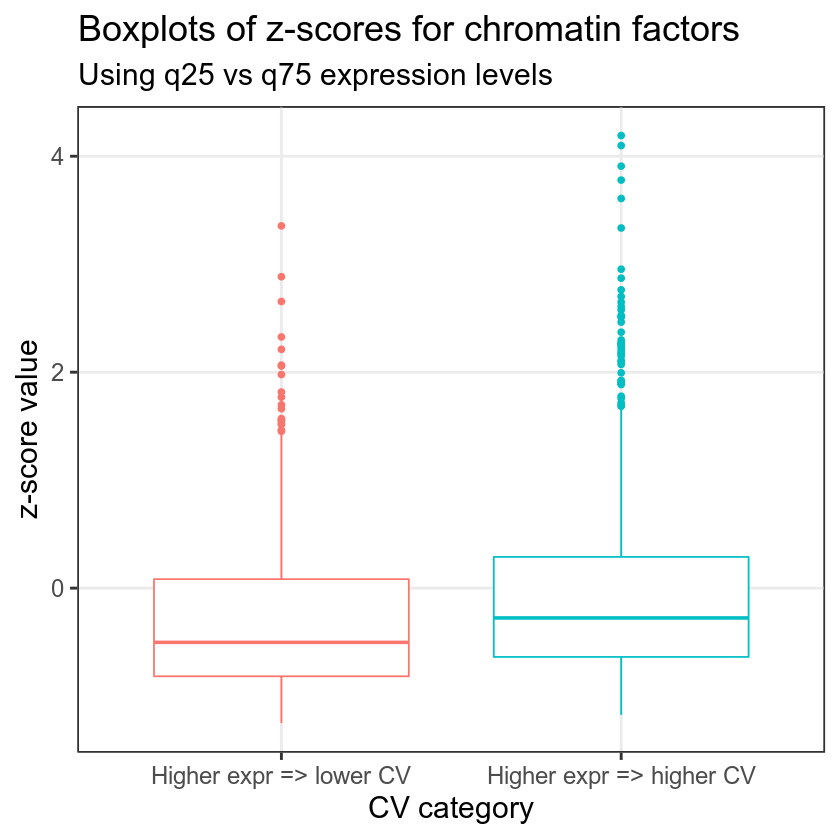

In [8]:
#Rest of the analysis

#First isolate the grouped factors by using the random designation

#Returns a 'logical list'
cond <- lapply(list_of_tables_up_down, function (list) list[[2]] == "N")

#Subsetting vector by atomic mask, unlisting it to place into vector format
grouped_list <- list_of_tables_up_down[unlist(cond)]

#Returns a new list with converted z-scores: for each entry in the grouped list, subtracts
#out the corresponding random mean scalar, and divides by the corresponding random sd
grouped_list_z <- lapply(grouped_list, function (list) {
  z_score_false <- (list[[3]][[1]] - random_false_mean)/random_false_sd
  z_score_true <- (list[[3]][[2]] - random_true_mean)/random_true_sd
  #reassign the list, and return it 
  list[[3]][[1]] = z_score_false
  list[[3]][[2]] = z_score_true
  return (list(list[[1]], list[[3]]))
})

#Make a dataframe out of this 'z-list': extract relevant elements from this new list &
#return a dataframe in wide format
grouped_z_name <- lapply(grouped_list_z, function (list) {
  list[[1]]
})

grouped_z_false <- lapply(grouped_list_z, function (list) {
  list[[2]][[1]]
})

grouped_z_true <- lapply(grouped_list_z, function (list) {
  list[[2]][[2]]
})

#The data.frame call: make a 3-col dataframe with name, numeric z-score for cv-low cond,
#and cv-hi condition
z_df <- data.frame(unlist(grouped_z_name), unlist(grouped_z_false),
                   unlist(grouped_z_true))

colnames(z_df) <- c("Chromatin factor name", "Higher_expression_meant_lower_CV",
                    "Higher_expression_meant_higher_CV")

#Return a long-format dataframe, keeping the first row as id variable (chromatin factor)
z_melt <- melt(z_df, id.vars = "Chromatin factor name")

z_melt

#Plotting out the z-scores for both conditions: (note that multiple theme calls means
#that last one can take precedence (?))
z_plot_unlabeled <- ggplot(z_melt, mapping = aes(x = variable, y = value)) + 
  geom_boxplot(aes(color = variable)) +
labs (title = 'Boxplots of z-scores for chromatin factors',
      subtitle = 'Using q25 vs q75 expression levels',
      x = 'CV category',
      y = "z-score value") + 
scale_x_discrete(labels = c("Higher expr => lower CV", "Higher expr => higher CV")) + 
theme_bw(18) +
theme(legend.position = "none") + 
theme(panel.background = element_rect(colour = "black"), panel.grid.minor = element_blank())

pdf(paste0(path, 'q25_q75_filtered_genes_CV_z_scores.pdf'), height = 12, width = 12)
z_plot_unlabeled
dev.off()

z_plot_unlabeled


[1] 17

[1] 6

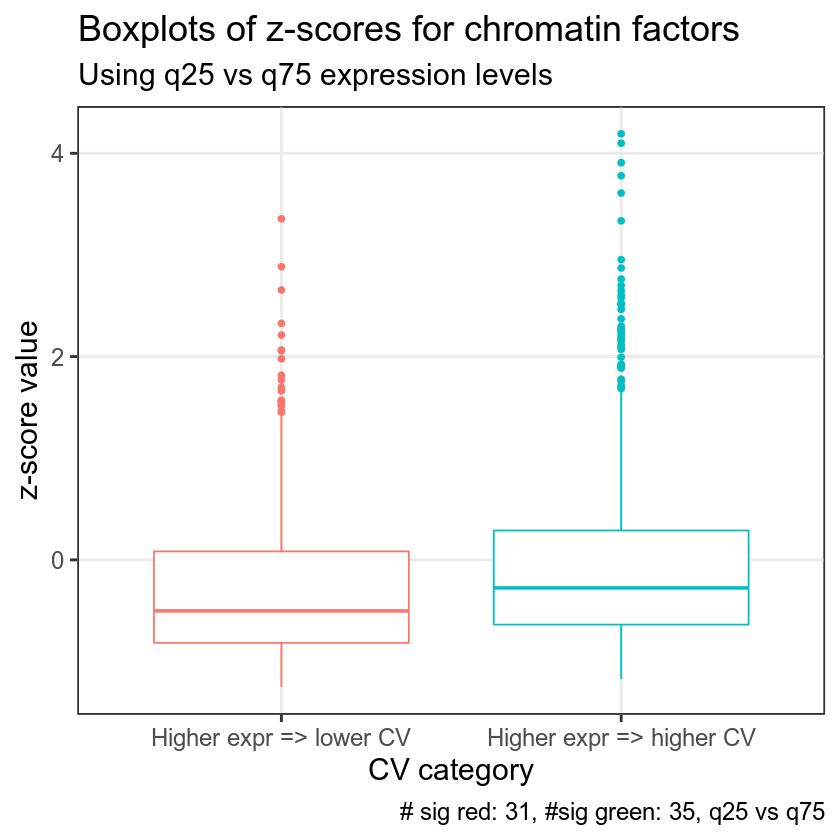

In [9]:
#Saving data, thresholding it
anti_threshold <- 1.5
corr_threshold <- 3
  
z_df_clean <- z_df[(z_df[,2] >= anti_threshold | z_df[,3] >= corr_threshold),]


z_df_lo <- z_df_clean[(z_df_clean[,2] >= anti_threshold), c(1, 2)]
z_df_up <- z_df_clean[(z_df_clean[,3] >= corr_threshold), c(1, 3)]

length(rownames(z_df_lo))
length(rownames(z_df_up))

z_plot_unlabeled + labs (caption = "# sig red: 31, #sig green: 35, q25 vs q75")

write.csv(z_df_lo, paste0(path, 'z_df_lowered_q25.txt'))
write.csv(z_df_up, paste0(path, 'z_df_up_q75.txt'))

In [10]:
save.image(file = paste0(path, 'end_save.RData'))

In [1]:
library(ggplot2)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(Seurat)
path = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q25_q75_greater_than_10FPKM_top2000DEGs/'
path2 = '/home/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q10_q90_greater_than_10FPKM_top2000DEGs/'


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [2]:
load(paste0(path, 'end_save.RData'))

In [5]:
#' ###Comparing magnitude of CV influence from q25/q75 analysis to q10/q90
#' 
#' Now, let's compare the analysis from using the bottom and top quartile to calculate CV,
#' to using the bottom and top 10/90%, respectively. Why? We should see a dosage dependency in
#' doing so. This means that there isn't any strict 'perfect expression level' that any factor
#' has to be at in order to influence CV. 
#' 
#' Should have two graphs: 
#' 
#' First, should have a venn diagram showing overlap between the two analyses: is the analysis using the q25/q75 condition a subset of using the q10/q90? 
#' 
#' The other: is a boxplot of the z-score distribution between q25/q75 and 
#' q10/q90; the z-scores in the q10/q90 comparison should all be markedly higher. Do this only
#' between the shared genes.
#' 
## ---- checking q25/q75 to q10/q90----------------------------------------------
#Data loading 
z_df_up_q75 <- read.csv(paste0(path, 'z_df_up_q75.txt'), stringsAsFactors=FALSE)

z_df_up_q90 <- read.csv(paste0(path2, 'z_df_up_q90.txt'), stringsAsFactors=FALSE)

#Make an elementary venn diagram from using the two names
venn_list_names_input <- list("Sig factors, from using q25 vs q75" =
                                z_df_up_q75$Chromatin.factor.name,
                              "Sig factors, from using q10 vs q90" =
                                z_df_up_q90$Chromatin.factor.name)


pdf(paste0(path, 'filtered_genes_venn.pdf'), height = 12, width = 12)
venn(venn_list_names_input, intersections = TRUE)
dev.off()

#look at intersected factors, plot their corresponding z-score distribution

intersected_names <- 
intersect (z_df_up_q75$Chromatin.factor.name, z_df_up_q90$Chromatin.factor.name)

z_df_up_q90_intersected <- 
z_df_up_q90[z_df_up_q90$Chromatin.factor.name %in% intersected_names,]

z_df_up_q90_intersected$quartile <- "From analysis using bottom 10% vs top 90%"

z_df_up_q75_intersected <- 
z_df_up_q75[z_df_up_q75$Chromatin.factor.name %in% intersected_names,]

z_df_up_q75_intersected$quartile <- "From analysis using bottom quartile vs top quartile"

z_comparison_melt <- rbind(z_df_up_q75_intersected, z_df_up_q90_intersected)


#Plotting out the z-scores for both conditions: 
z_plot_comparison <- ggplot(z_comparison_melt, 
mapping = aes(x = quartile, y = Higher_expression_meant_higher_CV)) + 
geom_boxplot() +
labs (title = 'Boxplots of z-scores for chromatin factors', 
      subtitle = 'Comparing factors resulting from using q25 vs q75, and q10 vs q90',
      x = 'Group',
      y = "z-score value") + 
  theme_bw(18) +
theme (legend.position = "none") +
  theme(panel.background = element_rect(colour = "black"), panel.grid.minor = element_blank())

pdf(paste0(path, 'z_plot_comparison_filtered_genes.pdf'), height = 12, width = 12)
z_plot_comparison
dev.off()

png 
  2

png 
  2

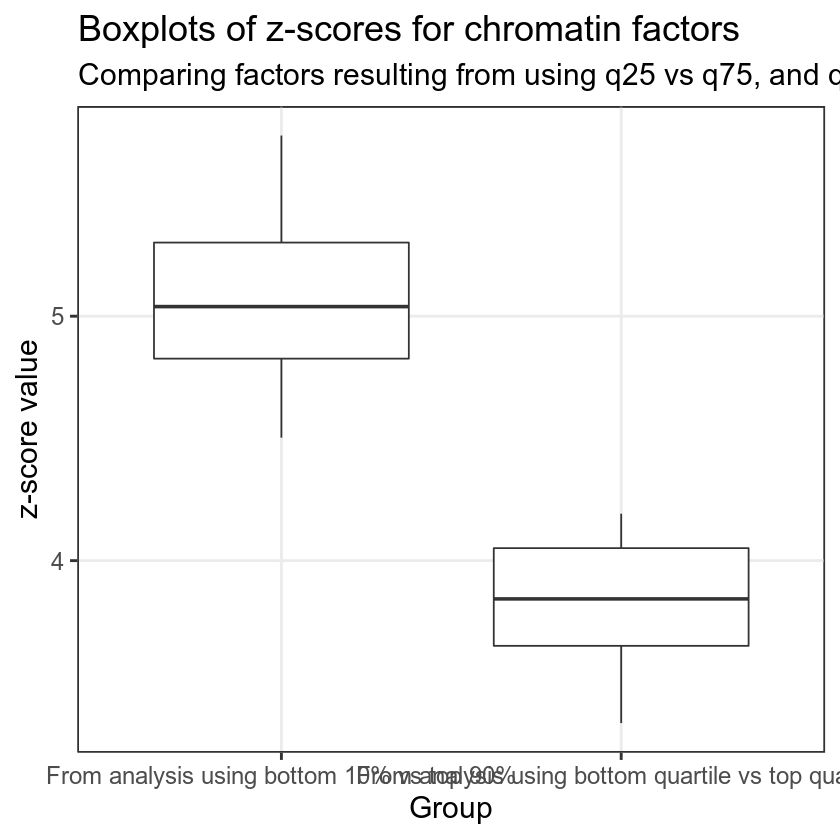

In [7]:
z_plot_comparison

[1] "AURKA" "AURKB" "CDC45" "CENPM" "CENPN" "H2AFZ"

Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (list[[2]] == "Y") {:
“the condition has length > 1 and only the first element will be used”


[1] "ADNP2"        "AIP"          "ANAPC7"       "ATP5G1"       "BSCL2"       
 [6] "LOC644822"    "CCNL1"        "CD63"         "CDK6"         "EHBP1L1"     
[11] "EIF3L"        "GPBP1L1"      "GRK4"         "GSTM3"        "FLJ22242"    
[16] "KCNH1"        "LYN"          "MFSD9"        "MLLT3"        "NIPAL3"      
[21] "FLJ14733"     "LOC144997"    "PCDHB4"       "KEN"          "LOC100505926"
[26] "LU1"          "PPIL4"        "PTPN7"        "RAB32"        "RAD51AP1"    
[31] "C20orf74"     "RPL7"         "SLC36A4"      "SP140L"       "ST8SIA2"     
[36] "STAT6"        "STON1"        "TCEB1"        "EMC4"         "TMOD2"       
[41] "UBE2V2"       "UTP14A"       "UTP23"        "YB1"          "LOC647655"   
[46] "ZNF652"

[1] FALSE

[1] TRUE

png 
  2

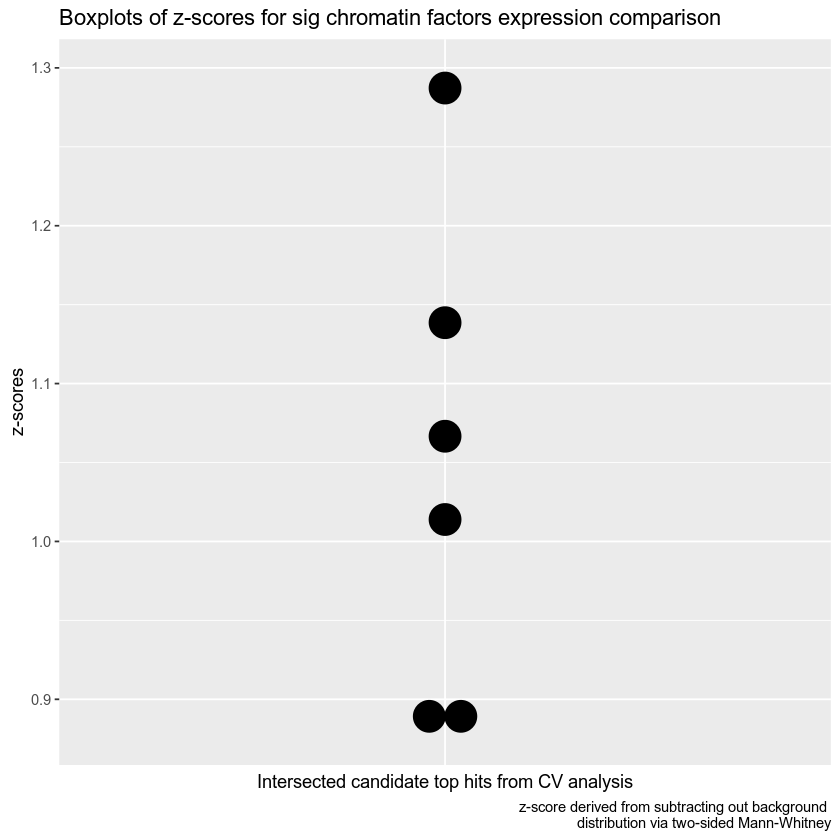

In [6]:
#' ###Expression validation for the top candidates identified previously
#' 
#' Additionally, look at **expression** of these factors: does it differ between the two groupings (check q10/q90 first, as this arguably is a more extreme version of the q25/q75 grouping)? If so, then this could be influencing the CV of the genes in question: the two aren't as independent as it seems. 
#' 
#' Run a Mann-Whitney test for expression, two-sided between the two groups. Basically, re-run the analysis but instead of using the asymptotic test, use the MW test for difference of populations.
## ------------------------------------------------------------------------------
#Look at the previously defined intersected names vector, and get a corresponding vector
#using the random groupings genes

intersected_names

names_of_random <- unlist(lapply(grouped_dataframes_list_with_CV_ratio_cleaned, 
                          function (list) {if (list[[2]] == "Y") {
                            return (list [[1]])
                          }}
                  ))

names_of_random

#Test that the correct names were pulled out 
test_names <- unlist(lapply(grouped_dataframes_list_with_CV_ratio_cleaned[509:546],
                            function (list) {list[[1]]}))

identical(test_names, names_of_random) #TRUE

#Now get the full corresponding data from the full dataset list

full_names <- c(intersected_names, names_of_random)

inter_logical_cond <- lapply(grouped_dataframes_list_with_CV_ratio_cleaned, function (list) { list[[1]] %in% full_names})

inter_list <- grouped_dataframes_list_with_CV_ratio_cleaned[unlist(inter_logical_cond)]

length(inter_list) == length(full_names) #TRUE

#Let's now repeat the entire analysis for this smaller intersected list subset. Let's
#apply a wilcoxon ranked sum test to the smaller list, instead of the asymptotic test for #CV used previously. Same workflow applies.

#Now, let's define a function that will compute the wilcoxon ranked sign test for 
#intersected_list that we just subsetted. 

wilcox_q10_q90 <- function (row, q25_entry, q75_entry, list_of_df, 
                                omitted_indices) { 
  #getting the gene name, which is in the specified name entry column 
  #(generally first column)
  gene_name <- list_of_df[[q25_entry]][row, 1]
  #get rows of interest
  q25_list <- t(list_of_df[[q25_entry]][row, omitted_indices]) 
  q75_list <- t(list_of_df[[q75_entry]][row, omitted_indices]) 
  #Need to take transpose to get this row into column format; corresponds to only numeric    indices
  test <- wilcox.test(q25_list, q75_list)
  return (list(gene_name, test$p.value))
}

df_intersect_p_vals <- pblapply(inter_list, asymp_test_applier, f = wilcox_q10_q90)



#Repeat relevant analysis using the previous analytical logic from code chunk called
#'q value calcs and z-score calculations'

#Apply previously written function that will append adjusted qvals, etc to the list of p #value dataframes object from earlier

appended_p_val_df_expression <- pblapply(seq_len(length((df_intersect_p_vals))), 
                                         append_cols_p_q, 
                                         df_intersect_p_vals, CV = FALSE)

#Subsetting the appended_p_val_df_expression dataset: focusing on col_of_sign_q, this is
#the number of genes that are actually significantly different between the two conditions
#that we'd like to compare: the top hit candidates only, + the random groupings we used
#originally. The difference here from the previous analysis using CV is that now there
#is no need to look at genes grouped by CV positive/negative correlation. Just 
#simply count the number of genes that are significantly different between the two 
#expression groupings, for both random and true groups, and then derive z-scores this way

list_genes_expression <-  
  pblapply(seq_len(length(appended_p_val_df_expression)), count_sig_qvals, 
                data = appended_p_val_df_expression, CV = FALSE)

#Get the random and grouped means and sds, using the random_designation tag. 

random_sig_genes <- unlist(lapply(list_genes_expression, function (list) 
  {if (list[[2]] == "Y") {list[[3]]}}))

random_sig_sd <- sd(random_sig_genes)
random_sig_mean <- mean(random_sig_genes)

#Return a 'logical list' of genes that are the top hits
cond <- lapply(list_genes_expression, function (list) list[[2]] == "N")

#Subsetting vector by atomic mask, unlisting it to place into vector format
grouped_list <- list_genes_expression[unlist(cond)]


#Returns a new list with converted z-scores: for each entry in the grouped list, subtracts
#out the random mean scalar, and divides by the random sd
grouped_list_z <- lapply(grouped_list, function (list) {
  z_score <- (list[[3]] - random_sig_mean)/random_sig_sd
  #reassign the list, and return it 
  list[[3]] = z_score
  return (list)
})

#Make a dataframe out of this 'z-list': extract relevant elements from this new list &
#return a dataframe in wide format
grouped_z_name <- lapply(grouped_list_z, function (list) {
  list[[1]]
})

grouped_z_z <- lapply(grouped_list_z, function (list) {
  list[[3]]
})

#The data.frame call: make a 3-col dataframe with name, numeric z-score for cv-low cond,
#and cv-hi condition

z_df <- data.frame(unlist(grouped_z_name), unlist(grouped_z_z), 'Normalized Z-score' )

colnames(z_df) <- c("Chromatin factor name", "Z", 'Factor')

write.csv(z_df, paste0(path, 'z_df_expression_check_q25_q75.txt'))



#Plotting out the z-scores for both conditions: 
z_plot <- ggplot(z_df, mapping = aes(Factor, Z)) + 
  geom_dotplot(binaxis = "y", stackdir = 'center', binwidth = 1/50) +
labs (title = 'Boxplots of z-scores for sig chromatin factors expression comparison',
      caption = 'z-score derived from subtracting out background 
      distribution via two-sided Mann-Whitney',
      y = 'z-scores', 
      x = 'Intersected candidate top hits from CV analysis') + 
theme (legend.position = "none",
       axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) 

z_plot

pdf(paste0(path, 'expression_plot_q25_q75.pdf'), width = 10, height = 10)
z_plot
dev.off()

In [8]:
save.image(file = paste0(path, 'end_save2.RData'))